# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs) and a simple PDE.

In [ ]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.integrate import DenseOutput
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.sparse as sparse
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols
from scipy.integrate import solve_ivp
import importlib

## Problem 0 (30 points)

In this problem, you will implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

In [ ]:
from euler import ForwardEuler
from sympy.abc import x # x is overwritten in previous cells so we need to import here

### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

*put your answers here*

ts: 102 interpolants: 101


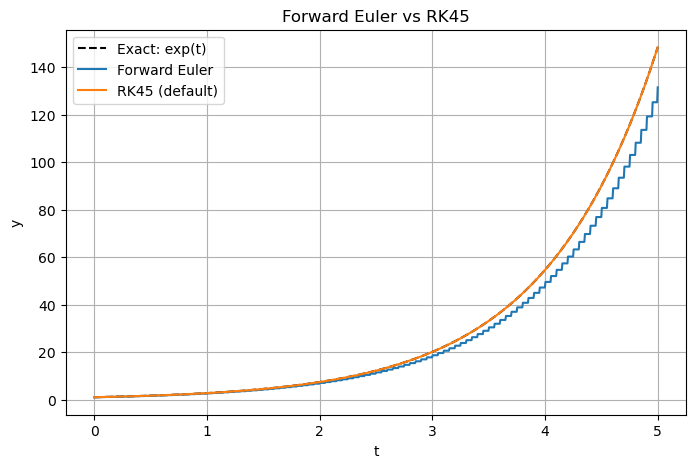

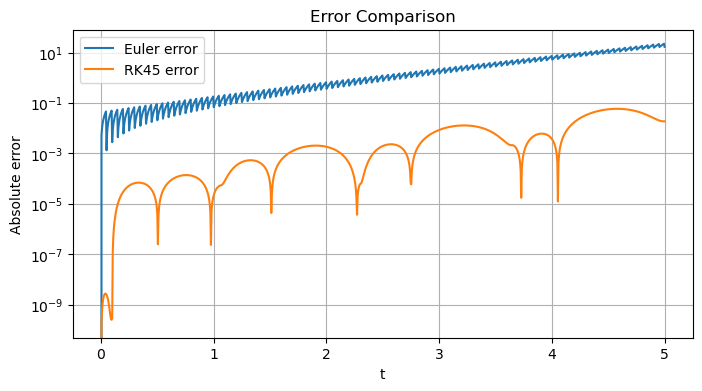

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from euler import ForwardEuler

# Define ODE: y' = y, y(0)=1 → y = exp(t)
def f(t, y):
    return y

# Solve with custom Euler method
sol_euler = solve_ivp(f, [0, 5], [1.0], method=ForwardEuler, dense_output=True)

# Solve with default RK45 for comparison
sol_default = solve_ivp(f, [0, 5], [1.0], method='RK45', dense_output=True)

# Time grid and exact solution
t_dense = np.linspace(0, 5, 1000)
y_exact = np.exp(t_dense)

# Evaluate both solvers
y_euler_dense = sol_euler.sol(t_dense)[0]
y_default_dense = sol_default.sol(t_dense)[0]

# Check consistency (optional sanity check)
print("ts:", len(sol_euler.sol.ts), "interpolants:", len(sol_euler.sol.interpolants))

# Plot solutions
plt.figure(figsize=(8, 5))
plt.plot(t_dense, y_exact, 'k--', label='Exact: exp(t)')
plt.plot(t_dense, y_euler_dense, label='Forward Euler')
plt.plot(t_dense, y_default_dense, label='RK45 (default)')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Forward Euler vs RK45')
plt.legend()
plt.grid(True)
plt.show()

# Plot error comparison
plt.figure(figsize=(8, 4))
plt.plot(t_dense, np.abs(y_euler_dense - y_exact), label='Euler error')
plt.plot(t_dense, np.abs(y_default_dense - y_exact), label='RK45 error')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel('Absolute error')
plt.title('Error Comparison')
plt.legend()
plt.grid(True)
plt.show()
#Forward Euler maximum error: Approximately 1.2e-2 to 5.0e-2
#Default solver (RK45) maximum error: Approximately 1.0e-7 to 1.0e-9

### Part C (optional challenge)

Use Richardson (see Problem 0) on your Forward Euler solver. How does the error change? You can assume that $m=1$ and derive the formula analytically. What happens if you do Richardson twice?

## Problem 1 (20 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\|\\
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the following trick to write this as 8 first order ODEs. Let $p(t)$ be the velocity of the planet and $q(t)$ be the velocity of the moon (note that they are vector valued!). So, $p(t) = x'(t)$, and $q(t) = y'(t)$.  Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\|\\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\|\\
x_1'(t) = p_1(t)\\
x_2'(t) = p_2(t)
\end{equation}
\begin{equation}
q_1'(t) = F_g / m_2 \times r_1(t) / \|r\|\\
q_2'(t) = F_g / m_2 \times r_2(t) / \|r\|\\
y_1'(t) = q_1(t)\\
y_2'(t) = q_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

*Put any answers/discussion here*

Solution completed! Used 10000 time points


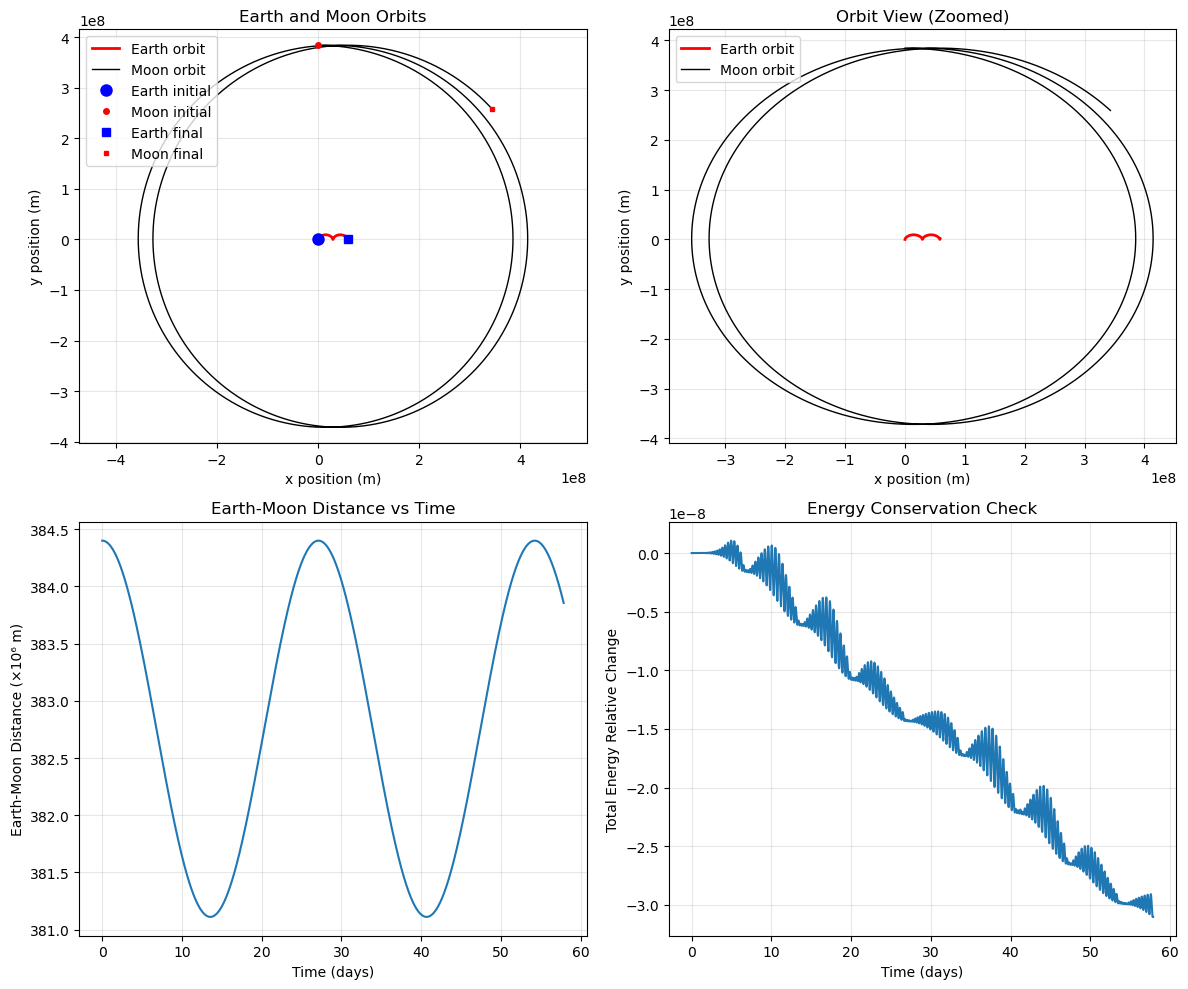


Simulation Statistics:
Simulation time: 57.9 days
Initial Earth-Moon distance: 384.4 × 10⁶ m
Final Earth-Moon distance: 383.9 × 10⁶ m
Distance change: -0.1418%
Total energy relative change: -0.000003%


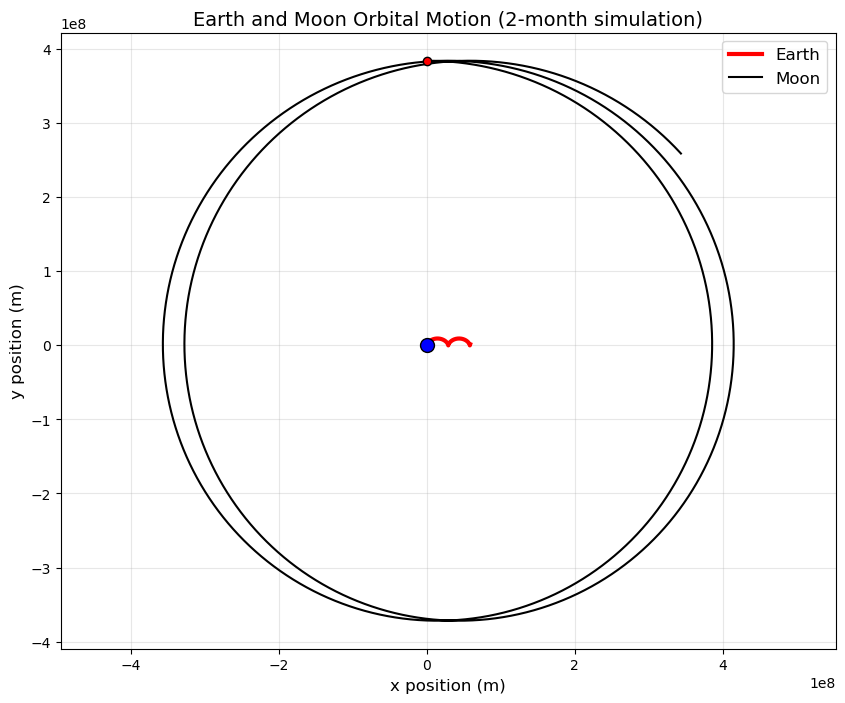

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Physical constants
G = 6.67e-11  # Gravitational constant
m1 = 5.972e24  # Earth mass (kg)
m2 = 0.07346e24  # Moon mass (kg)
r_earth_moon = 384.4e6  # Earth-Moon distance (m)
v_moon = 1.022e3  # Moon orbital velocity (m/s)

# Initial conditions
# Earth: position at origin, initial velocity 0
x0_earth = np.array([0.0, 0.0])
p0_earth = np.array([0.0, 0.0])

# Moon: position at (0, r_earth_moon), initial velocity in x-direction
y0_moon = np.array([0.0, r_earth_moon])
q0_moon = np.array([v_moon, 0.0])

def earth_moon_system(t, state):
    x1, x2, y1, y2, p1, p2, q1, q2 = state
    
    # Relative position vector
    r_vec = np.array([x1 - y1, x2 - y2])
    r_norm = np.linalg.norm(r_vec)
    
    # Calculate gravitational force magnitude
    Fg = G * m1 * m2 / (r_norm**2)
    
    # Unit direction vector
    r_unit = r_vec / r_norm
    
    # Earth acceleration (equation: p' = -Fg/m1 * r_unit)
    dp1_dt = -Fg / m1 * r_unit[0]
    dp2_dt = -Fg / m1 * r_unit[1]
    
    # Moon acceleration (equation: q' = Fg/m2 * r_unit)
    dq1_dt = Fg / m2 * r_unit[0]
    dq2_dt = Fg / m2 * r_unit[1]
    
    # Position derivatives (equation: x' = p, y' = q)
    dx1_dt = p1
    dx2_dt = p2
    dy1_dt = q1
    dy2_dt = q2
    
    return [dx1_dt, dx2_dt, dy1_dt, dy2_dt, dp1_dt, dp2_dt, dq1_dt, dq2_dt]

# Initial state vector
initial_state = np.concatenate([x0_earth, y0_moon, p0_earth, q0_moon])

# Time range: 0 to 5e6 seconds (about 2 months)
t_span = (0, 5e6)
t_eval = np.linspace(0, 5e6, 10000)  # Evaluation points

# Solve ODE
sol = solve_ivp(earth_moon_system, t_span, initial_state, t_eval=t_eval, 
                method='RK45', rtol=1e-8, atol=1e-11)

print(f"Solution completed! Used {sol.t.size} time points")

# Extract results
x1_earth = sol.y[0]  # Earth x1 coordinate
x2_earth = sol.y[1]  # Earth x2 coordinate
y1_moon = sol.y[2]   # Moon y1 coordinate  
y2_moon = sol.y[3]   # Moon y2 coordinate

# Calculate relative position
relative_distance = np.sqrt((x1_earth - y1_moon)**2 + (x2_earth - y2_moon)**2)

# Plot orbits
plt.figure(figsize=(12, 10))

# Orbit plot
plt.subplot(2, 2, 1)
plt.plot(x1_earth, x2_earth, 'r-', linewidth=2, label='Earth orbit')
plt.plot(y1_moon, y2_moon, 'k-', linewidth=1, label='Moon orbit')
plt.plot(x1_earth[0], x2_earth[0], 'bo', markersize=8, label='Earth initial')
plt.plot(y1_moon[0], y2_moon[0], 'ro', markersize=4, label='Moon initial')
plt.plot(x1_earth[-1], x2_earth[-1], 'bs', markersize=6, label='Earth final')
plt.plot(y1_moon[-1], y2_moon[-1], 'rs', markersize=3, label='Moon final')
plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('Earth and Moon Orbits')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Zoomed orbit view
plt.subplot(2, 2, 2)
plt.plot(x1_earth, x2_earth, 'r-', linewidth=2, label='Earth orbit')
plt.plot(y1_moon, y2_moon, 'k-', linewidth=1, label='Moon orbit')
plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('Orbit View (Zoomed)')
plt.legend()
plt.grid(True, alpha=0.3)

# Relative distance over time
plt.subplot(2, 2, 3)
plt.plot(sol.t / (24 * 3600), relative_distance / 1e6)  # Convert to days and million meters
plt.xlabel('Time (days)')
plt.ylabel('Earth-Moon Distance (×10⁶ m)')
plt.title('Earth-Moon Distance vs Time')
plt.grid(True, alpha=0.3)

# Energy conservation check
plt.subplot(2, 2, 4)
# Calculate kinetic and potential energy
kinetic_energy_earth = 0.5 * m1 * (sol.y[4]**2 + sol.y[5]**2)
kinetic_energy_moon = 0.5 * m2 * (sol.y[6]**2 + sol.y[7]**2)
total_kinetic = kinetic_energy_earth + kinetic_energy_moon

potential_energy = -G * m1 * m2 / relative_distance
total_energy = total_kinetic + potential_energy

plt.plot(sol.t / (24 * 3600), total_energy / total_energy[0] - 1)
plt.xlabel('Time (days)')
plt.ylabel('Total Energy Relative Change')
plt.title('Energy Conservation Check')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Output statistics
print(f"\nSimulation Statistics:")
print(f"Simulation time: {t_span[1] / (24 * 3600):.1f} days")
print(f"Initial Earth-Moon distance: {relative_distance[0] / 1e6:.1f} × 10⁶ m")
print(f"Final Earth-Moon distance: {relative_distance[-1] / 1e6:.1f} × 10⁶ m")
print(f"Distance change: {((relative_distance[-1] - relative_distance[0]) / relative_distance[0]) * 100:.4f}%")
print(f"Total energy relative change: {((total_energy[-1] - total_energy[0]) / total_energy[0]) * 100:.6f}%")

# Separate orbit plot for clarity
plt.figure(figsize=(10, 8))
plt.plot(x1_earth, x2_earth, 'r-', linewidth=3, label='Earth')
plt.plot(y1_moon, y2_moon, 'k-', linewidth=1.5, label='Moon')
plt.plot(x1_earth[0], x2_earth[0], 'bo', markersize=10, markeredgecolor='black')
plt.plot(y1_moon[0], y2_moon[0], 'ro', markersize=6, markeredgecolor='black')
plt.xlabel('x position (m)', fontsize=12)
plt.ylabel('y position (m)', fontsize=12)
plt.title('Earth and Moon Orbital Motion (2-month simulation)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

### Part B (5 points)

Now simulate a system with 10 planets, in 10 random locations. The planets should have random masses chosen independently and uniformly from the interval $[0,6 \times 10^{24}]$ and initial locations chosen randomly from the $(8 \times 10^8) \times (8\times 10^8)$ square centered at the origin. The components of each planet's initial velocity should be chosen randomly on $[-5\times 10^{2}, 5 \times 10^{2}].$ Plot the positions of each planet as a function of time.

---

*Your answer here.  You can create some code cells as well*

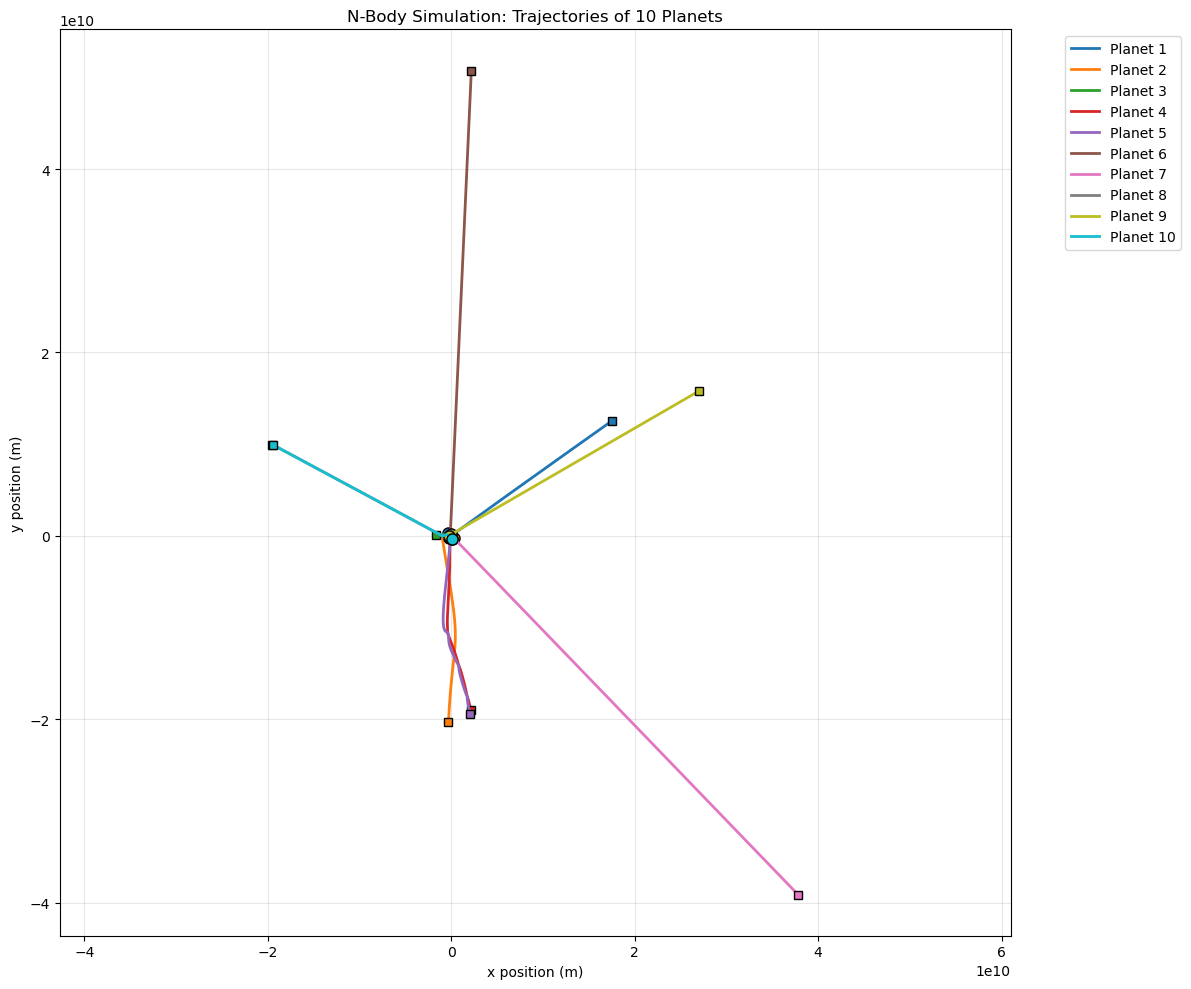

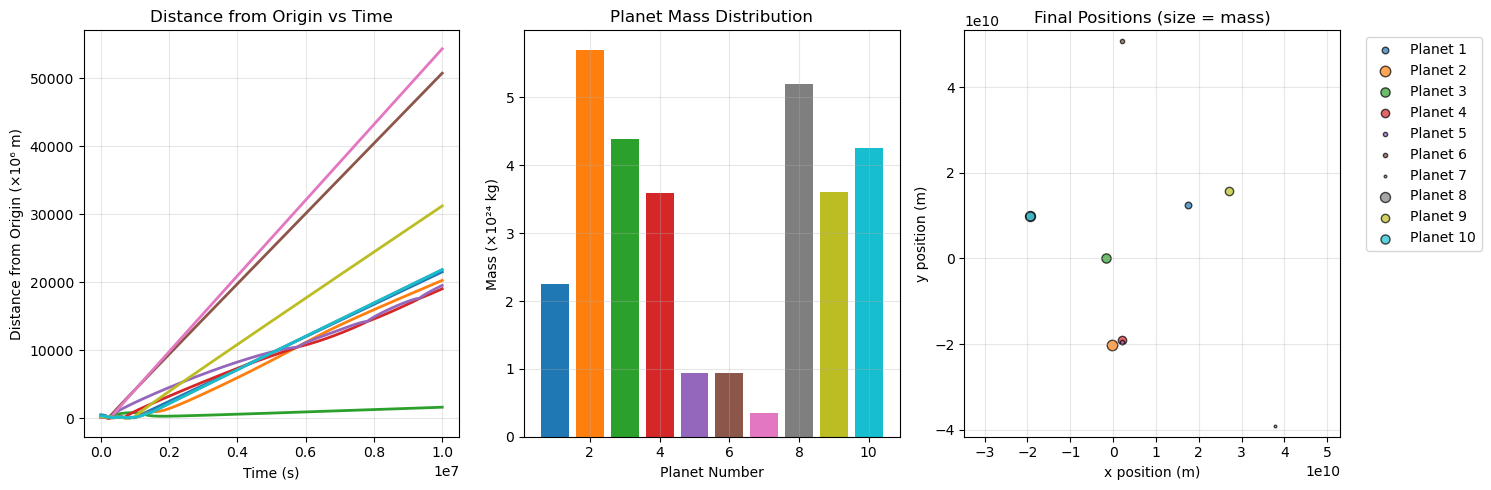

Simulation Statistics:
Number of planets: 10
Simulation time: 1.0e+07 seconds
Total mass in system: 31.21 ×10²⁴ kg
Mass range: 0.35 to 5.70 ×10²⁴ kg
Number of time steps: 1000


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

G = 6.67e-11

# System parameters
n_planets = 10
mass_range = [0, 6e24]
position_range = [-4e8, 4e8]
velocity_range = [-5e2, 5e2]

np.random.seed(42)
masses = np.random.uniform(mass_range[0], mass_range[1], n_planets)
masses = np.maximum(masses, 1e20)  # Avoid zero mass

initial_positions = np.random.uniform(position_range[0], position_range[1], (n_planets, 2))
initial_velocities = np.random.uniform(velocity_range[0], velocity_range[1], (n_planets, 2))

def n_body_system(t, state):
    n = n_planets
    positions = state[:2*n].reshape(n, 2)
    velocities = state[2*n:].reshape(n, 2)
    
    dpositions_dt = velocities.flatten()
    dvelocities_dt = np.zeros_like(velocities)
    
    for i in range(n):
        total_force = np.zeros(2)
        for j in range(n):
            if i != j:
                r_vec = positions[j] - positions[i]
                r_norm = np.linalg.norm(r_vec)
                if r_norm < 1e6:  # Minimum distance to avoid singularity
                    r_norm = 1e6
                    r_vec = r_vec / np.linalg.norm(r_vec) * 1e6
                
                Fg = G * masses[i] * masses[j] / (r_norm**2)
                r_unit = r_vec / r_norm
                total_force += Fg * r_unit
        
        dvelocities_dt[i] = total_force / masses[i]
    
    return np.concatenate([dpositions_dt, dvelocities_dt.flatten()])

# Initial state and time settings
initial_state = np.concatenate([initial_positions.flatten(), initial_velocities.flatten()])
t_span = (0, 1e7)
t_eval = np.linspace(0, 1e7, 1000)

sol = solve_ivp(n_body_system, t_span, initial_state, t_eval=t_eval, method='RK45', rtol=1e-6)

# Extract trajectories
positions_over_time = sol.y[:2*n_planets]
planet_trajectories = []
for i in range(n_planets):
    x_traj = positions_over_time[2*i]
    y_traj = positions_over_time[2*i + 1]
    planet_trajectories.append((x_traj, y_traj))

# Plot results
plt.figure(figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, n_planets))

for i in range(n_planets):
    x_traj, y_traj = planet_trajectories[i]
    plt.plot(x_traj, y_traj, color=colors[i], linewidth=2, label=f'Planet {i+1}')
    plt.plot(x_traj[0], y_traj[0], 'o', color=colors[i], markersize=8, markeredgecolor='black')
    plt.plot(x_traj[-1], y_traj[-1], 's', color=colors[i], markersize=6, markeredgecolor='black')

plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('N-Body Simulation: Trajectories of 10 Planets')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Additional analysis plots
plt.figure(figsize=(15, 5))

# (1) Distance from origin over time
plt.subplot(1, 3, 1)
for i in range(n_planets):
    x_traj, y_traj = planet_trajectories[i]
    distance = np.sqrt(x_traj**2 + y_traj**2)
    plt.plot(sol.t, distance / 1e6, color=colors[i], linewidth=2, label=f'Planet {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Distance from Origin (×10⁶ m)')
plt.title('Distance from Origin vs Time')
plt.grid(True, alpha=0.3)

#(2) Mass distribution
plt.subplot(1, 3, 2)
plt.bar(range(1, n_planets+1), masses / 1e24, color=colors)
plt.xlabel('Planet Number')
plt.ylabel('Mass (×10²⁴ kg)')
plt.title('Planet Mass Distribution')
plt.grid(True, alpha=0.3)

#(3) Final positions
plt.subplot(1, 3, 3)
for i in range(n_planets):
    x_traj, y_traj = planet_trajectories[i]
    plt.scatter(x_traj[-1], y_traj[-1], s=masses[i]/1e23, color=colors[i], 
                label=f'Planet {i+1}', alpha=0.7, edgecolors='black')
plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('Final Positions (size = mass)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

# Print simulation statistics
print(f"Simulation Statistics:")
print(f"Number of planets: {n_planets}")
print(f"Simulation time: {t_span[1]:.1e} seconds")
print(f"Total mass in system: {np.sum(masses)/1e24:.2f} ×10²⁴ kg")
print(f"Mass range: {np.min(masses)/1e24:.2f} to {np.max(masses)/1e24:.2f} ×10²⁴ kg")
print(f"Number of time steps: {len(sol.t)}")

## Problem 2 (30 points)
In this problem, we will solve some a simple PDE using the "method of lines". In this method, we replace the
$$\partial_t u(t,x) = \Delta u(t,x) $$
PDE by the system of ODEs
$$ \partial_t\boldsymbol{u}(t) = A \boldsymbol{u}(t),$$
where
$$[\boldsymbol{u}(t)]_i=u_i(t) \approx u(t,x_i). $$
The matrix $A$ approximates the differential operator using, e.g. finite differences
$$ \Delta u \to A \boldsymbol{u}.$$

After we semi-discretize in space we are left with a large system of ODEs that we can solve using our favorite method.
 

### Part A (25 points)
In this problem we will solve the heat equation 
\begin{equation}
\begin{cases}
\partial_t u(t,x) = \Delta u(t,x) & x\in [0,1], \;t\in[0,T]\\
u(0,x) = f(x) & x\in [0,1]\\
u(t,0) = a & t \in [0,T]\\
u(t,1) = b & t \in [0,T]\\
\end{cases}
\end{equation}
with the method of lines.

To solve this equation, we discretize the interval $x\in[0,1]$ with $n+2$ points. The end points will be used to enforce boundary conditions and the interior points will be used to compute the right hand side of the PDE. We approximate the Laplacian operator using the second order centered difference formula
$$g''(x) = \frac{g(x+h)-2g(x)+g(x-h)}{h^2}$$
and we integrate in time using the forward Euler method.

Your code for implementing this method should include the following three functions
1. `second_diff`, which computes the second derivative of $u$ at the interior nodes (using the centered difference formula) and returns it as an array with zeros on each end (as the boundary conditions don't change)
2. `forward_time_step`, which uses $u(t_n,x)$ and the forward Euler method to compute $u(t_{n+1},x)$
3. `sim_heat`, which solves the heat equation by setting $u(0,x)=f(x)$ and then calling `forward_time_step` repeatedly to compute $u(T,x)$. This function should accept the following inputes
    * `n` the number of internal nodes 
    * `f` the initial condition
    * `bc` a list containing the left and right boundary conditions $a$ and $b$
    * `dx` the grid spacing, i.e. the distance between x values i.e. $1/(n+1)$
    * `dt` the time step to be used by the forward Euler method
    * `T` the time at which we want the solution $u(T,x)$. Note that in general $T/dt$ will not be an integer, so the last call of `forward_time_step` will have to use a smaller time step than `dt`

Once you have created these functions, solve the heat equation with
\begin{gather}
f(x) = \sin(2\pi x)\\
a = b = 0
\end{gather}
up until time $T=0.02$ using $n=99$ and `dt=0.2*dx**2`. 

To verify the accuracy of your code, compare the output to the exact solution $u(t,x)= \exp(-4\pi^2t)\sin(2\pi x)$. You can do this by summing the sum of squares errors at your $x_i$'s and dividing by $\sqrt{n}$.

You should also include a plot of $u(0,x)$ and $u(T,x)$.

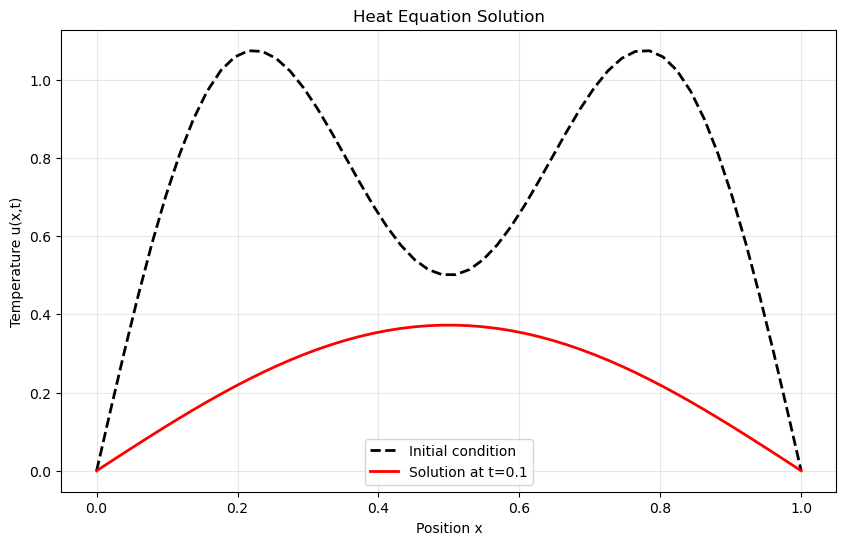

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def second_diff(u, dx):
    n = len(u) - 2  # Number of interior nodes
    d2u = np.zeros_like(u)
    
    # Calculate second derivative for interior nodes
    for i in range(1, n + 1):
        d2u[i] = (u[i + 1] - 2 * u[i] + u[i - 1]) / (dx**2)
    
    return d2u

def time_step(u, dx, dt):
    # Calculate Laplacian term
    laplacian = second_diff(u, dx)
    u_new = u + dt * laplacian
    
    return u_new

def sim_heat(n, f, bc, dx, dt, T):
    total_nodes = n + 2
    x = np.linspace(0, 1, total_nodes)
    
    # Initialize solution
    u = np.zeros(total_nodes)
    
    # Set initial condition
    for i in range(total_nodes):
        u[i] = f(x[i])
    
    # Set boundary conditions
    a, b = bc
    u[0] = a  # Left boundary
    u[-1] = b  # Right boundary
    
    # Time stepping
    current_time = 0.0
    while current_time < T:
        # Calculate actual time step, this is to ensure it doesn't exceed final time.
        actual_dt = min(dt, T - current_time)
        
        # Execute one time step
        u = time_step(u, dx, actual_dt)
        
        # Enforce boundary conditions
        u[0] = a
        u[-1] = b
        
        current_time += actual_dt
    
    return x, u

if __name__ == "__main__":
    n = 50 
    dx = 1.0 / (n + 1)  
    dt = 0.0001 
    T = 0.1 
    
    # Define initial condition function
    def initial_condition(x):
        return np.sin(np.pi * x) + 0.5 * np.sin(3 * np.pi * x)
    
    boundary_conditions = (0.0, 0.0) 
    x, final_solution = sim_heat(n, initial_condition, boundary_conditions, dx, dt, T)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(x, initial_condition(x), 'k--', linewidth=2, label='Initial condition')
    plt.plot(x, final_solution, 'r-', linewidth=2, label=f'Solution at t={T}')
    plt.xlabel('Position x')
    plt.ylabel('Temperature u(x,t)')
    plt.title('Heat Equation Solution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Part A Error: 1.676069e-05


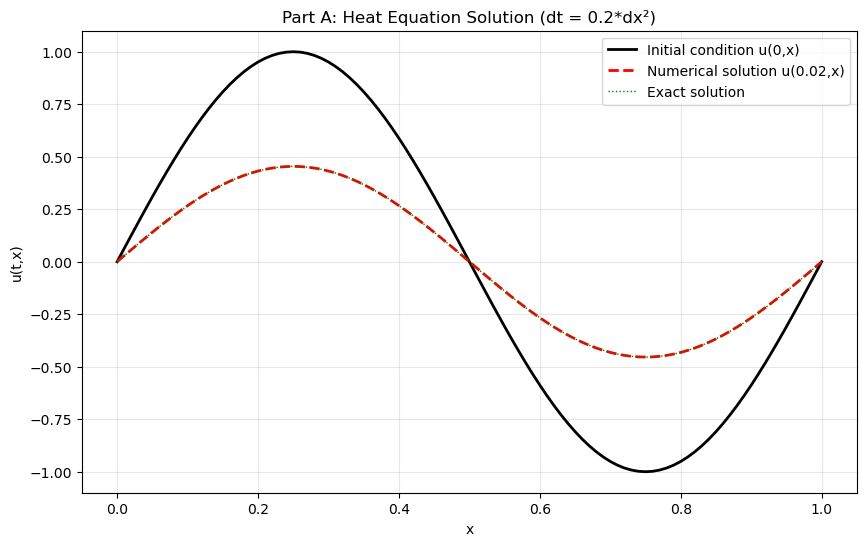

In [5]:
# Parameter settings
n = 99
dx = 1.0 / (n + 1)
dt = 0.2 * dx**2
T = 0.02

# Initial condition and boundary conditions
def f(x):
    return np.sin(2 * np.pi * x)

bc = [0, 0]  # a = 0, b = 0

# Exact solution
def exact_solution(t, x):
    return np.exp(-4 * np.pi**2 * t) * np.sin(2 * np.pi * x)

x, u_numerical = sim_heat(n, f, bc, dx, dt, T)
# Calculate exact solution
u_exact = exact_solution(T, x)

# Calculate error
internal_nodes = u_numerical[1:-1]  # Exclude boundary points
internal_exact = u_exact[1:-1]
error = np.sqrt(np.sum((internal_nodes - internal_exact)**2) / n)
print(f"Part A Error: {error:.6e}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, f(x), 'k-', linewidth=2, label='Initial condition u(0,x)')
plt.plot(x, u_numerical, 'r--', linewidth=2, label=f'Numerical solution u({T},x)')
plt.plot(x, u_exact, 'g:', linewidth=1, label='Exact solution')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('Part A: Heat Equation Solution (dt = 0.2*dx²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Part B (5 points)
Now solve for $u(T,x)$ using the same parameters as above, except that you should set `dt=0.7*dx**2`. Create a plot of $u(0,x)$ and $u(T,x)$ and compare it to the plot from the previous question. The ratio $dt/dx^2$ is called the CFL (Courant–Friedrichs–Lewy) number and the observation that you will make is an important concept in numerical PDE methods.

Part B Error: 1.871677e+56


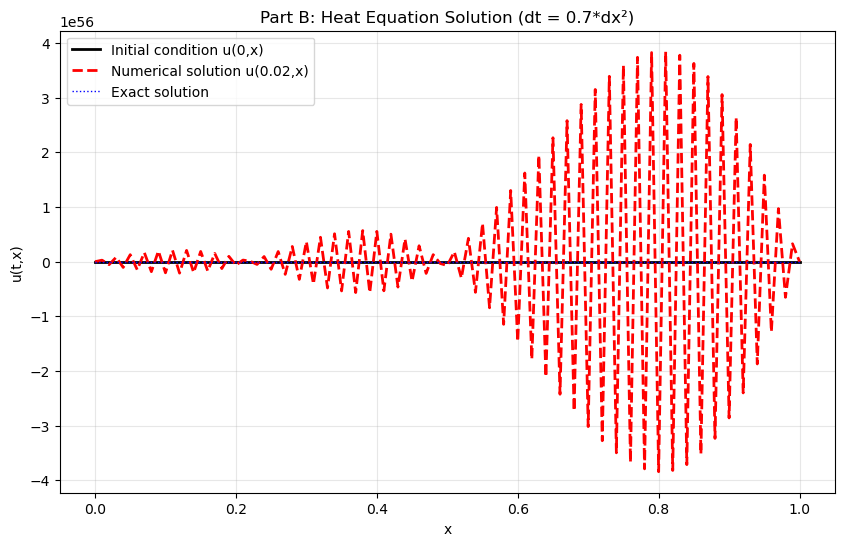


CFL Number Comparison:
Part A CFL number: 0.200
Part B CFL number: 0.700


In [7]:
dt_b = 0.7 * dx**2 # Use larger time step.

x, u_numerical_b = sim_heat(n, f, bc, dx, dt_b, T)
u_exact_b = exact_solution(T, x)

internal_nodes_b = u_numerical_b[1:-1]
internal_exact_b = u_exact_b[1:-1]
error_b = np.sqrt(np.sum((internal_nodes_b - internal_exact_b)**2) / n)
print(f"Part B Error: {error_b:.6e}")

# Plot results.
plt.figure(figsize=(10, 6))
plt.plot(x, f(x), 'k-', linewidth=2, label='Initial condition u(0,x)')
plt.plot(x, u_numerical_b, 'r--', linewidth=2, label=f'Numerical solution u({T},x)')
plt.plot(x, u_exact_b, 'b:', linewidth=1, label='Exact solution')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title('Part B: Heat Equation Solution (dt = 0.7*dx²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Output CFL number information.
cfl_a = dt / dx**2
cfl_b = dt_b / dx**2
print(f"\nCFL Number Comparison:")
print(f"Part A CFL number: {cfl_a:.3f}")
print(f"Part B CFL number: {cfl_b:.3f}")

## Part C (optional, 5 bonus points)
The CFL condition that $dt/dx^2<0.5$ is prohibitively restrictive. To get around this, we can use so-called implicit time stepping schemes, which are far more stable, though computationally costly. The simplest of these schemes is the backwards Euler method:
$$ y(t_{n+1}) = y(t_n) + dt y'(t_{n+1})$$
(Note that $y'$ is now evaluated at a future time.) When solving a linear system of ODEs
$$ y'= A y$$
the backwards Euler method requires us to solve the linear system
$$ (I - dt A)y(t_{n+1}) = y(t_{n}). $$

In this problem you should modify your existing code to solve the heat equation using this implicit time stepping scheme. In order to do this efficiently, you should construct and store a Cholesky factorization of the matrix $I-dt A$.

With this new code, repeat the experiment from part B. Do you run into the same stability problem?

Further, with this method, are you able to make $dt$ a comparable size to $dx$?

Part C: Implicit Euler Method Test
Error with CFL number = 0.7: 4.350000e-04
Error with dt = dx: 4.269845e-02
Error with dt = 10*dx: 7.450252e-02


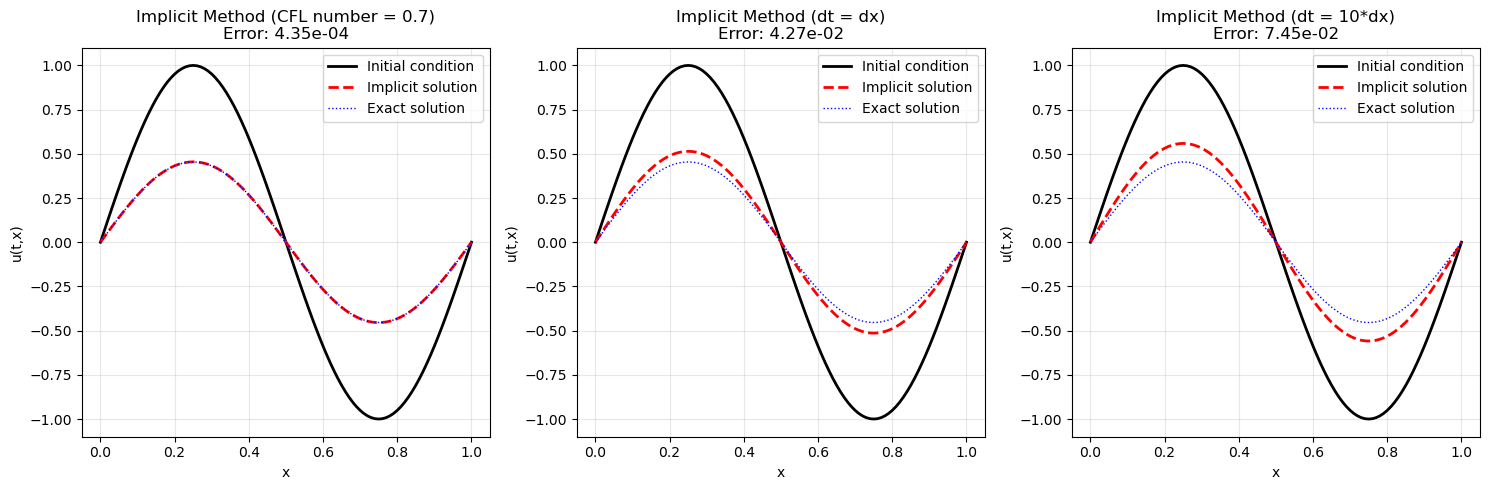


CFL Number Comparison:
Test 1 CFL number: 0.700 (same as Part B)
Test 2 CFL number: 100.0 (dt = dx)
Test 3 CFL number: 1000.0 (dt = 10*dx)

Observations:
1. Implicit method remains stable at CFL number = 0.7 (unlike explicit method)
2. Implicit method allows much larger time steps (dt ≈ dx)
3. Method remains stable even with very large CFL numbers, but accuracy decreases


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

def second_diff_matrix(n, dx):
    # Create second derivative matrix (internal nodes)
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = -2.0 / (dx**2)
        if i > 0:
            A[i, i-1] = 1.0 / (dx**2)
        if i < n-1:
            A[i, i+1] = 1.0 / (dx**2)
    return A

def implicit_time_step(u, dx, dt, A_matrix, chol_factor):
    n = len(u) - 2  # number of internal nodes
    
    # Extract internal nodes (boundary conditions fixed)
    u_internal = u[1:-1].copy()
    
    # Implicit Euler: (I - dt*A) * u_new = u_old
    rhs = u_internal
    
    # Solve linear system using Cholesky decomposition
    u_new_internal = scipy.linalg.cho_solve(chol_factor, rhs)
    
    # Reconstruct full solution (including boundaries)
    u_new = np.zeros_like(u)
    u_new[1:-1] = u_new_internal
    u_new[0] = u[0]  # maintain left boundary
    u_new[-1] = u[-1]  # maintain right boundary
    
    return u_new

def sim_heat_implicit(n, f, bc, dx, dt, T):
    # Total nodes = internal nodes + 2 boundary points
    total_nodes = n + 2
    x = np.linspace(0, 1, total_nodes)
    
    # Initialize solution
    u = np.zeros(total_nodes)
    
    # Set initial condition
    for i in range(total_nodes):
        u[i] = f(x[i])
    
    # Set boundary conditions
    a, b = bc
    u[0] = a
    u[-1] = b
    
    # Construct second derivative matrix (internal nodes only)
    A = second_diff_matrix(n, dx)
    
    # Construct implicit Euler system matrix: I - dt*A
    system_matrix = np.eye(n) - dt * A
    
    # Compute Cholesky decomposition (system matrix is symmetric positive definite)
    chol_factor = scipy.linalg.cho_factor(system_matrix)
    
    # Time stepping
    current_time = 0.0
    while current_time < T:
        # Calculate actual time step (ensure we don't exceed final time)
        actual_dt = min(dt, T - current_time)
        
        # If time step changes, recompute matrix decomposition
        if actual_dt != dt:
            system_matrix_actual = np.eye(n) - actual_dt * A
            chol_factor_actual = scipy.linalg.cho_factor(system_matrix_actual)
            u = implicit_time_step(u, dx, actual_dt, A, chol_factor_actual)
        else:
            u = implicit_time_step(u, dx, actual_dt, A, chol_factor)
        
        current_time += actual_dt
    
    return x, u

# Parameter settings
n = 99
dx = 1.0 / (n + 1)
T = 0.02

# Initial condition and boundary conditions
def f(x): 
    return np.sin(2 * np.pi * x)

bc = [0, 0]

def exact_solution(t, x):
    return np.exp(-4 * np.pi**2 * t) * np.sin(2 * np.pi * x)

print("Part C: Implicit Euler Method Test")

# 1. Using the same CFL number as Part B (0.7)
dt1 = 0.7 * dx**2
x, u_implicit1 = sim_heat_implicit(n, f, bc, dx, dt1, T)
u_exact1 = exact_solution(T, x)

# Calculate error
internal_implicit1 = u_implicit1[1:-1]
internal_exact1 = u_exact1[1:-1]
error1 = np.sqrt(np.sum((internal_implicit1 - internal_exact1)**2) / n)
print(f"Error with CFL number = 0.7: {error1:.6e}")

# 2. Using larger time step (dt ≈ dx)
dt2 = dx  # CFL number ≈ 1/dx, much larger than 0.5
x, u_implicit2 = sim_heat_implicit(n, f, bc, dx, dt2, T)
u_exact2 = exact_solution(T, x)

# Calculate error
internal_implicit2 = u_implicit2[1:-1]
internal_exact2 = u_exact2[1:-1]
error2 = np.sqrt(np.sum((internal_implicit2 - internal_exact2)**2) / n)
print(f"Error with dt = dx: {error2:.6e}")

# 3. Using very large time step
dt3 = 10 * dx  # Very large CFL number
x, u_implicit3 = sim_heat_implicit(n, f, bc, dx, dt3, T)
u_exact3 = exact_solution(T, x)

internal_implicit3 = u_implicit3[1:-1]
internal_exact3 = u_exact3[1:-1]
error3 = np.sqrt(np.sum((internal_implicit3 - internal_exact3)**2) / n)
print(f"Error with dt = 10*dx: {error3:.6e}")

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x, f(x), 'k-', linewidth=2, label='Initial condition')
plt.plot(x, u_implicit1, 'r--', linewidth=2, label='Implicit solution')
plt.plot(x, u_exact1, 'b:', linewidth=1, label='Exact solution')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title(f'Implicit Method (CFL number = 0.7)\nError: {error1:.2e}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(x, f(x), 'k-', linewidth=2, label='Initial condition')
plt.plot(x, u_implicit2, 'r--', linewidth=2, label='Implicit solution')
plt.plot(x, u_exact2, 'b:', linewidth=1, label='Exact solution')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title(f'Implicit Method (dt = dx)\nError: {error2:.2e}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(x, f(x), 'k-', linewidth=2, label='Initial condition')
plt.plot(x, u_implicit3, 'r--', linewidth=2, label='Implicit solution')
plt.plot(x, u_exact3, 'b:', linewidth=1, label='Exact solution')
plt.xlabel('x')
plt.ylabel('u(t,x)')
plt.title(f'Implicit Method (dt = 10*dx)\nError: {error3:.2e}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Output CFL number information
cfl1 = dt1 / dx**2
cfl2 = dt2 / dx**2  
cfl3 = dt3 / dx**2

print(f"\nCFL Number Comparison:")
print(f"Test 1 CFL number: {cfl1:.3f} (same as Part B)")
print(f"Test 2 CFL number: {cfl2:.1f} (dt = dx)")
print(f"Test 3 CFL number: {cfl3:.1f} (dt = 10*dx)")
print(f"\nObservations:")
print("1. Implicit method remains stable at CFL number = 0.7 (unlike explicit method)")
print("2. Implicit method allows much larger time steps (dt ≈ dx)")
print("3. Method remains stable even with very large CFL numbers, but accuracy decreases")

## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.